In [4]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [64]:
import os
#data_file_path = os.path.join(os.path.dirname(__file__), "YX.csv")
data_file_path = os.path.join(os.getcwd(), "Data\YX.csv")
#data_file_path = os.path.join(os.getcwd(), "Compustat.csv")

In [65]:
import pandas as pd
#finalData = pd.read_csv(data_file_path, nrows=10_000)
finalData = pd.read_csv(data_file_path)
finalData


# finalData = dataset.map(..., num_parallel_calls=10)
# finalData = dataset.prefetch(buffer_size)

,returns,MktCap,gvkey,fdateq,datadate,datacqtr,curcdq,accdq,acoq,acoxq,...,city,fyrc,ggroup,gind,gsector,gsubind,idbflag,loc,naics,sic
0,51.662612,1.522417e+09,1166,20101105,20110204,2010Q3,EUR,87.2820,70.5220,70.5220,...,Almere,12,4530,453010,45,45301010,B,NLD,333242,3559
1,4.705882,1.594061e+09,1166,20110330,20110506,2010Q4,EUR,63.8670,67.9700,67.9700,...,Almere,12,4530,453010,45,45301010,B,NLD,333242,3559
2,-25.597342,1.169086e+09,1166,20110811,20111104,2011Q2,EUR,284.1220,82.1470,82.1470,...,Almere,12,4530,453010,45,45301010,B,NLD,333242,3559
3,23.676880,1.445889e+09,1166,20120331,20120504,2011Q4,EUR,110.9440,97.0650,97.0650,...,Almere,12,4530,453010,45,45301010,B,NLD,333242,3559
4,-2.103645,1.391343e+09,1166,20120821,20121106,2012Q2,EUR,195.2640,95.7600,95.7600,...,Almere,12,4530,453010,45,45301010,B,NLD,333242,3559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57142,-15.362035,2.690859e+09,352058,20220530,20220805,2022Q1,TRY,189.3170,147.2988,137.7548,...,Istanbul,12,1510,151040,15,15104050,I,TUR,331210,3317
57143,18.970238,5.796980e+09,352242,20220509,20220805,2021Q2,CNY,38.0655,12.5528,11.5111,...,Dalian,12,1510,151010,15,15101050,I,CHN,325180,2810
57144,0.000000,2.134020e+10,352246,20220423,20220506,2021Q4,CNY,388.0477,31.6198,27.7038,...,Shenzhen,12,2010,201060,20,20106020,I,CHN,333249,3559
57145,0.000000,2.536682e+10,352430,20220422,20220506,2021Q3,TWD,288.0150,80.3290,46.4610,...,Taoyuan,12,2010,201010,20,20101010,I,TWN,488190,4581


In [66]:
# import dask.dataframe
# finalData = dask.dataframe.read_csv(data_file_path)
# finalData
finalData.dtypes


testDF = pd.DataFrame({
    "A": [1, 2],
    "B": [6, 7]
}
)


In [67]:
# trainY = finalData["returns"][0:20].compute()
# trainY
# trainX = finalData.loc[:, finalData.columns != "returns"]
# trainX

import numpy as np

finalData["fdateq"] = pd.to_datetime(finalData["fdateq"], format = "%Y%m%d")
finalData["datadate"] = pd.to_datetime(finalData["datadate"], format = "%Y%m%d")
#finalData["fdateq"] = pd.to_datetime(finalData["datacqtr"], format = "%Y%q") #check quarter format


#Currently not grouped by quarter
finalData = finalData.sort_values(by=['datacqtr', "fdateq"])

trainSize = round(len(finalData.index)*0.4)
validationSize = round(len(finalData.index)*0.7)

Y = finalData["returns"]
Y = np.asarray(Y).astype('float32')
yTrain, yVal, yTest = Y[:trainSize], Y[trainSize:validationSize], Y[validationSize:]

X = finalData.loc[:, finalData.columns != "returns"]


factorCols = ["gvkey",  "sic", "naics", "loc", "idbflag",
              "gsubind", "ggroup", "gind", "gsector",
              "fic", "city", "fyrc",
              "curcdq", "exchg"]

X[factorCols] = X[factorCols].astype("str")



X = X.select_dtypes(include=[np.number])
#X = X.dropna()





In [70]:
X.dtypes

finalData


MktCap      float64
accdq       float64
acoq        float64
acoxq       float64
actq        float64
             ...   
wcapopcy    float64
xinty       float64
xoproy      float64
xopry       float64
xsgay       float64
Length: 86, dtype: object


In [71]:
#Ratio data
#xRatioData = finalData.apply(lambda x: x/finalData["revtq"])
xRatioData = X.div(finalData["MktCap"].values, axis=0)
xRatioData = xRatioData.loc[:, xRatioData.columns != "MktCap"]


#xRatioData = xRatioData.dropna()
xRatioData


,accdq,acoq,acoxq,actq,ancq,aoq,apq,atq,capsq,ceqq,...,piy,recchy,revty,saley,txty,wcapopcy,xinty,xoproy,xopry,xsgay
3966,1.827080e-08,4.655206e-09,1.805494e-09,3.026809e-07,6.773129e-07,1.040870e-07,3.597960e-08,9.799937e-07,1.061128e-07,5.874240e-07,...,4.219771e-08,-1.413750e-08,2.429616e-07,2.429616e-07,1.559219e-08,-1.400269e-08,1.065998e-08,0.000000e+00,1.687129e-07,9.454357e-09
5085,1.422769e-07,4.098587e-08,2.650338e-08,4.783486e-07,2.166928e-06,8.197020e-07,1.040159e-07,2.645276e-06,3.652187e-07,7.986805e-07,...,1.470974e-07,-3.343454e-09,3.520982e-07,3.432231e-07,2.928523e-08,-4.297599e-08,3.805697e-08,3.880841e-08,2.042718e-07,6.291376e-08
33558,8.508781e-08,2.115358e-08,1.447966e-08,1.390736e-06,4.682935e-07,6.275792e-08,5.383793e-07,1.859029e-06,3.871295e-08,7.429541e-07,...,1.289855e-07,-1.197460e-07,2.301325e-06,2.301325e-06,5.818709e-08,-3.201288e-07,1.960410e-08,0.000000e+00,2.190002e-06,3.486059e-07
9105,3.813836e-09,8.031183e-09,8.031183e-09,5.643761e-07,4.489067e-07,7.622465e-08,4.762088e-08,1.013283e-06,1.457198e-08,8.857210e-07,...,2.832391e-08,-3.950509e-09,1.783391e-07,1.783391e-07,1.490390e-09,-4.997036e-08,1.757228e-10,2.240140e-08,1.417042e-07,5.613367e-08
37158,3.488438e-08,3.874148e-09,3.618397e-10,1.333477e-07,8.717622e-08,9.369944e-09,1.987845e-08,2.205240e-07,2.643451e-08,9.246805e-08,...,-1.172664e-08,-1.177084e-09,3.246138e-08,3.246138e-08,-3.675231e-09,1.111031e-08,5.127642e-10,4.635085e-10,4.207760e-08,1.672293e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46409,2.121284e-08,4.654846e-08,4.654846e-08,4.178770e-07,2.030095e-06,3.538931e-07,1.990119e-07,2.447972e-06,2.664684e-07,7.331377e-07,...,2.117159e-08,-1.111912e-08,5.584386e-07,5.579184e-07,2.244893e-08,-4.735684e-08,3.236007e-08,0.000000e+00,4.319756e-07,4.895179e-08
49859,1.233889e-08,1.170597e-08,1.170597e-08,2.413652e-07,4.304594e-07,1.438525e-07,4.977592e-08,6.718247e-07,2.495970e-08,5.334215e-07,...,9.371600e-08,-3.699736e-08,2.258353e-07,2.241760e-07,1.397631e-08,-4.274799e-08,9.300971e-10,3.324398e-09,1.185996e-07,1.184662e-08
54962,8.422732e-08,3.200543e-08,2.818470e-08,3.211635e-07,5.328534e-07,1.459861e-07,5.086893e-08,8.540168e-07,3.533179e-08,2.918825e-07,...,6.612283e-08,-1.125159e-08,3.078046e-07,3.078046e-07,1.130317e-08,-5.926277e-08,4.441465e-09,0.000000e+00,1.782922e-07,3.436258e-08
56268,1.147960e-08,6.659249e-09,6.659249e-09,3.515109e-07,1.568503e-07,4.302630e-08,1.601056e-08,5.083612e-07,1.711224e-07,3.743546e-07,...,9.136180e-09,1.415054e-08,6.429135e-08,6.066056e-08,2.409920e-09,-1.668754e-09,3.274873e-09,1.087061e-08,5.142323e-08,1.791970e-08


In [11]:
#Winsorised data
import scipy


XArray = np.asarray(xRatioData).astype('float32')
numberOfVariables = XArray.shape[1]

xWinData = scipy.stats.mstats.winsorize(XArray, limits = (0.05, 0.95))
#yWinData = scipy.stats.mstats.winsorize(XArray, limits = (0.05, 0.95))


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_X = scaler.fit_transform(XArray)
#scaled_X = np.apply_along_axis(func1d=scaler.fit_transform, axis=1, arr=X)


xTrain, xVal, xTest = scaled_X[:trainSize,:], scaled_X[trainSize:validationSize,:], scaled_X[validationSize:, :]



scaled_winX = scaler.fit_transform(xWinData)
xWinTrain, xWinVal, xWinTest = scaled_winX[:trainSize,:], scaled_winX[trainSize:validationSize,:], scaled_winX[validationSize:, :]



#scaled_X = scaled_X.apply(lambda x : x.reshape(-1, 1))
# droppedCols = ["ajexdi", "prccd", "trfd"]
# trainX.drop(droppedCols, axis=1, inplace=True)
# trainX['gvkey'] = trainX['gvkey'].astype(object)
# trainX['gvkey'] = trainX['gvkey'].astype(object)

#trainX.dtypes

In [13]:
#finalData.iloc[:trainSize,:] 
#finalData.iloc[trainSize:validationSize,:]
finalData.iloc[validationSize:, :]

,returns,MktCap,gvkey,fdateq,datadate,datacqtr,curcdq,accdq,acoq,acoxq,...,city,fyrc,ggroup,gind,gsector,gsubind,idbflag,loc,naics,sic
51735,0.961538,1.153024e+10,317888,2020-08-14,2020-11-06,2020Q2,CNY,1.405225e+03,827.0714,827.0714,...,Laiyang,12,3020,302020,30,30202030,I,CHN,3116,2011
52641,-15.964912,1.022270e+10,319073,2020-08-14,2020-11-06,2020Q2,TWD,1.480500e+01,236.5080,236.5080,...,Zhongshan,12,4530,453010,45,45301020,I,TWN,334413,3674
52650,131.536210,2.256087e+10,319080,2020-08-14,2020-11-06,2020Q2,CNY,3.272490e+01,57.1814,56.7845,...,Quanzhou,12,4520,452030,45,45203015,I,CHN,334413,3674
52816,21.997847,1.994720e+10,319250,2020-08-14,2020-11-06,2020Q2,CNY,1.202319e+03,834.1811,834.1811,...,Zhongshan,12,4530,453010,45,45301020,I,CHN,3351,3640
53687,105.278592,1.326559e+10,320286,2020-08-14,2020-11-06,2020Q2,TWD,1.457370e+02,19.9980,3.7720,...,New Taipei City,12,4530,453010,45,45301020,I,TWN,334413,3674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46409,0.000000,1.187936e+10,296665,2022-07-31,2022-08-05,2022Q2,MXN,2.519950e+02,552.9660,552.9660,...,Mexico City,12,1510,151020,15,15102010,I,MEX,327310,3241
49859,21.166013,3.311719e+10,313370,2022-07-31,2022-08-05,2022Q2,CNY,4.086292e+02,387.6687,387.6687,...,Chengdu,12,1510,151010,15,15101010,I,CHN,325180,2810
54962,35.806308,2.631814e+13,323216,2022-07-31,2022-08-05,2022Q2,VND,2.216707e+06,842323.6787,741769.0246,...,Hanoi,12,2010,201020,20,20102010,I,VNM,32711,3260
56268,38.144836,2.765237e+09,326496,2022-07-31,2022-08-05,2022Q2,CNY,3.174380e+01,18.4144,18.4144,...,Beijing,12,4520,452030,45,45203010,I,CHN,334519,3829


In [14]:



# groupedY = Y.groupby(["state", "gender"])["last_name"].count()
# yTrain, yVal, yTest = Y[:trainSize], Y[trainSize:validationSize], Y[validationSize:]



# groupedX = scaled_X.groupby(["state", "gender"])["last_name"].count()
# xTrain, xVal, xTest = scaled_X[:trainSize,:], scaled_X[trainSize:validationSize,:], scaled_X[validationSize:, :]




In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [16]:
# model = Sequential([
#     Dense(units=16,  activation='relu'), #input_shape=(, 10, numberOfVariables),
#     Dense(units=32, activation='relu'),
#     Dense(units=1)
# ])


In [17]:
# model = tf.keras.Sequential()

# model.add(Dense(units=10,  activation='relu'))
# model.add(tf.keras.layers.Dropout(.5))
# model.add(Dense(units=10, activation='relu'))
# model.add(Dense(units=1))

In [18]:
# model.compile(optimizer="sgd",  # Adam(learning_rate=0.0001),
#               loss="MeanSquaredError", #'tf.keras.losses.MeanSquaredError()',
#               metrics=['accuracy'])

In [19]:
# model.fit(x=xTrain, y=yTrain,
#           batch_size=10, epochs=30, verbose=2)


In [20]:
# loss_and_metrics = model.evaluate(xVal, yVal, batch_size=128)

# model.predict(xVal, batch_size=128)

In [62]:
def NNfunction(modelType, layers, hidUnits, actvFunc, dropout, L1, L2):
    
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, verbose=1, restore_best_weights=True) #Can this be taken out from the loop? => Less computing

    #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
    #callback = tf.keras.callbacks.BackupAndRestore(backup_dir="/tmp/backup")


    model = tf.keras.Sequential()

    if modelType == "LSTM":
        model.add(tf.keras.layers.LSTM(units=hidUnits, input_shape=(2,)))
    elif modelType == "GRU":
        model.add(tf.keras.layers.GRU(units=hidUnits))
    elif modelType == "SimpleRNN":
        # keras.layers.SimpleRNN(1, input_shape=[None, 1])
        model.add(tf.keras.layers.SimpleRNN(units=hidUnits))
    elif modelType == "Linear":
        model.add(Dense(units=1,
                        kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2)))   #insert lasso and ridge here
    else:
        try:
            for n in range(0, layers):
                model.add(Dense(units=hidUnits,
                                activation=actvFunc,
                                kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2)))
                model.add(tf.keras.layers.Dropout(dropout))
                # scaler.fit_transform
                # tf.keras.layers.BatchNormalization(
        except:
            model.add(Dense(units=hidUnits, activation=actvFunc,
                            kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2)))
            model.add(tf.keras.layers.Dropout(dropout))

            
        model.add(Dense(units=1))



    model.compile(optimizer="RMSprop",  # Adam(learning_rate=0.0001) #RMSprop #sgd
                  loss="MeanSquaredError",  # 'tf.keras.losses.MeanSquaredError()'  #Huber   #MeanAbsoluteError
                  metrics=["MeanAbsoluteError"]) #accuracy




    # model.fit(x=xTrain, y=yTrain,
    #           batch_size=16, epochs=epo, verbose=2)

    #loss_and_metrics = model.evaluate(xVal, yVal, batch_size=128)
    


    history = model.fit(x=xWinTrain, y=yTrain,
              batch_size=32, epochs=100,
              callbacks= [callback], verbose=2, validation_data = (xWinVal, yVal))

    loss_and_metrics = model.evaluate(xWinVal, yVal, batch_size=32)
    
    epochs_EarlyStopping = len(history.history['loss'])
    #history.history[]




    # quarters = len(yVal)
    # CV = []
    # for q in range(0, quarters):

    #     model.fit(x=xTrain, y=yTrain,
    #           batch_size=16, epochs=epo, verbose=2)

    #     validationError = model.evaluate(xVal, yVal, batch_size=128)
    #     CV = [CV, validationError]


    
    
    try:
        loss_and_metrics = [x for x in loss_and_metrics]
    except:     
        print(loss_and_metrics)

    return loss_and_metrics, model, epochs_EarlyStopping

    #model.predict(xVal, batch_size=128)

    





In [50]:
#Hyper-Parameters
NNModelType = {"Forward"} #, "LSTM", "GRU"}
hiddenLayers = {2, 3, 4}
hiddenUnits = {2, 3, 4, 5, 10}
activationFunc = {"relu", "sigmoid", "tanh"} #etc. https://keras.io/api/layers/activations/
dropOut = {0.5, 0.2, 0}
#epochs = [100] #Just choose best model. => Run for 100 epochs, but if 20th epoch is the best, choose it, i.e. early stopping
#inputSize = numberOfVariables #ncol(trainXPools[[1]])
#other parameters: loss func, node structure, location of the regularization function
batchSize = {8, 16, 32, 64}
optim = {"RMSprop", "Adam", "sgd"}


none = {"NA"}

L1L2Grid = 10**np.linspace(start=3, stop=-5, num=3) #3 and -10
L1L2Grid = set(np.append(L1L2Grid, 0))


NNParams = {"Model type": NNModelType,  # , "LSTM", "GRU"},
            "Hidden layers": hiddenLayers,
            "Hidden units": hiddenUnits,
            "Activation function": activationFunc,
            "Dropout": dropOut,
            "L1": L1L2Grid,
            "L2": L1L2Grid
            }

LinearParams = {"Model type": {"Linear"},
               "Hidden layers": none,
               "Hidden units": none,
               "Activation function": none,
               "Dropout": none,
               "L1": L1L2Grid,
               "L2": L1L2Grid
               }



import itertools
import pandas as pd
NNGrid = pd.DataFrame(itertools.product(
    *NNParams.values()), columns=NNParams.keys())

linearGrid = pd.DataFrame(itertools.product(
    *LinearParams.values()), columns=LinearParams.keys())


#Random grid search
#import random
#random.seed(2302)
randomNNGrid = NNGrid.sample(n=16)

HPGrid = pd.concat([linearGrid, randomNNGrid])


# hyperParams = np.concatenate((LinearParams, NNParams, RNNParams))
#hyperParams = np.concatenate(grid, LinearParams)







In [51]:
MSEMatrix = pd.DataFrame()
pd.options.mode.chained_assignment = None


#validationSize = 2 #length(validXPools)
#HPsize = len(hyperParams.index)
HPsize = np.shape(HPGrid)[0]
#HPsize = 20

for n in range(0, HPsize):
  print("\n")
  print("Model ", str(n+1), " out of ", str(HPsize))

  HP = HPGrid.iloc[n]
  CV = NNfunction(*HP)

  #a = pd.DataFrame([CV])
  newMSE = HPGrid.iloc[[n]]

  MSE = CV[0][0]
  MAE = CV[0][1]
  Epochs = CV[2]
  ModelPointer = CV[1]

  # newMSE['MSE'] = MSE
  # newMSE['MAE'] = MAE

  newMSE.loc[:,"Epochs"] = Epochs
  newMSE.loc[:,"MSE"] = MSE
  newMSE.loc[:,"MAE"] = MAE
  newMSE.loc[:,"ModelPointer"] = ModelPointer

  MSEMatrix = pd.concat((MSEMatrix, newMSE), axis=0)
  
  # newMSE = a.join(b)
  # newMSE2 = pd.concat([b, a])
  #newMSE = pd.concat([b, a], axis=1, ignore_index=True, sort=False)
  #newMSE =  pd.concat(HPGrid.iloc[[n]], CV)
  #newMSE = np.concatenate((HP, CV))
  #MSEMatrix = np.concatenate((MSEMatrix, newMSE))
  #MSEMatrix = pd.concat(MSEMatrix, newMSE)
  #MSEMatrix = pd.concat([MSEMatrix, [HP, CV]])

finalResults = MSEMatrix

#finalResults[:,-1] = apply(finalResults[,-1], MARGIN=2, FUN=as.numeric)
#finalResults = finalResults[order(finalResults[,"MSE"]),]
#finalResults <- apply(finalResults, 2, as.character)

#write.csv2(finalResults, "results3.csv", row.names = FALSE)


#pd.DataFrame.to_csv(MSEMatrix, "resultsPython.csv")


#finalResults = finalResults[order(finalResults[,"MSE"]),]

formattedMSEMatrix = finalResults.sort_values(by=["MSE"], axis = 0)
formattedMSEMatrix




Model  1  out of  32
Epoch 1/100
715/715 - 4s - loss: 3279.9531 - accuracy: 0.0730 - val_loss: 2556.5088 - val_accuracy: 0.0391 - 4s/epoch - 5ms/step
Epoch 2/100
715/715 - 2s - loss: 1912.8470 - accuracy: 0.0083 - val_loss: 2555.4868 - val_accuracy: 5.8329e-05 - 2s/epoch - 3ms/step
Epoch 3/100
715/715 - 2s - loss: 1908.4888 - accuracy: 0.0000e+00 - val_loss: 2554.4131 - val_accuracy: 5.8329e-05 - 2s/epoch - 3ms/step
Epoch 4/100
715/715 - 2s - loss: 1904.6379 - accuracy: 0.0000e+00 - val_loss: 2553.8345 - val_accuracy: 5.8329e-05 - 2s/epoch - 3ms/step
Epoch 5/100
715/715 - 2s - loss: 1901.3330 - accuracy: 0.0000e+00 - val_loss: 2553.5078 - val_accuracy: 5.8329e-05 - 2s/epoch - 3ms/step
Epoch 6/100
715/715 - 2s - loss: 1898.4131 - accuracy: 0.0000e+00 - val_loss: 2553.4351 - val_accuracy: 5.8329e-05 - 2s/epoch - 3ms/step
Epoch 7/100
715/715 - 2s - loss: 1895.8660 - accuracy: 0.0000e+00 - val_loss: 2553.5737 - val_accuracy: 5.8329e-05 - 2s/epoch - 3ms/step
Epoch 8/100
715/715 - 2s - los

,Model type,Hidden layers,Hidden units,Activation function,Dropout,L1,L2,Epochs,MSE,MAE,ModelPointer
1047,Forward,3,4,sigmoid,0.2,0.00000,0.00001,4,2510.911133,0.000058,<keras.engine.sequential.Sequential object at ...
1949,Forward,4,5,relu,0.0,0.00001,0.00000,9,2510.911621,0.000058,<keras.engine.sequential.Sequential object at ...
14,Linear,NA,NA,NA,NA,0.00001,0.10000,9,2510.912598,0.000058,<keras.engine.sequential.Sequential object at ...
5,Linear,NA,NA,NA,NA,0.00000,0.00000,9,2510.913086,0.000058,<keras.engine.sequential.Sequential object at ...
671,Forward,2,10,relu,0.2,0.00001,0.00001,9,2510.913330,0.000058,<keras.engine.sequential.Sequential object at ...
15,Linear,NA,NA,NA,NA,0.00001,0.00001,9,2510.913574,0.000058,<keras.engine.sequential.Sequential object at ...
229,Forward,2,3,relu,0.2,0.00000,0.00000,9,2510.914307,0.000058,<keras.engine.sequential.Sequential object at ...
10,Linear,NA,NA,NA,NA,0.10000,0.10000,9,2510.915039,0.000058,<keras.engine.sequential.Sequential object at ...
7,Linear,NA,NA,NA,NA,0.00000,0.00001,9,2510.916504,0.000058,<keras.engine.sequential.Sequential object at ...
1950,Forward,4,5,relu,0.0,0.00001,0.10000,9,2510.916748,0.000058,<keras.engine.sequential.Sequential object at ...


In [48]:
formattedMSEMatrix = finalResults.sort_values(by=["MSE"], axis = 0)
formattedMSEMatrix

,Model type,Hidden layers,Hidden units,Activation function,Dropout,L1,L2,Epochs,MSE,MAE,ModelPointer
5,Linear,NA,NA,NA,NA,0.00000,0.00000,9,2510.908691,0.000058,<keras.engine.sequential.Sequential object at ...
4,Linear,NA,NA,NA,NA,0.00000,1000.00000,9,2510.909180,0.000058,<keras.engine.sequential.Sequential object at ...
1080,Forward,3,4,relu,0.0,0.10000,1000.00000,9,2510.909912,0.000058,<keras.engine.sequential.Sequential object at ...
6,Linear,NA,NA,NA,NA,0.00000,0.10000,9,2510.909912,0.000058,<keras.engine.sequential.Sequential object at ...
8,Linear,NA,NA,NA,NA,0.10000,1000.00000,9,2510.909912,0.000058,<keras.engine.sequential.Sequential object at ...
196,Forward,2,3,relu,0.5,0.00000,1000.00000,9,2510.910400,0.000058,<keras.engine.sequential.Sequential object at ...
10,Linear,NA,NA,NA,NA,0.10000,0.10000,9,2510.910645,0.000058,<keras.engine.sequential.Sequential object at ...
7,Linear,NA,NA,NA,NA,0.00000,0.00001,9,2510.910889,0.000058,<keras.engine.sequential.Sequential object at ...
13,Linear,NA,NA,NA,NA,0.00001,0.00000,9,2510.910889,0.000058,<keras.engine.sequential.Sequential object at ...
15,Linear,NA,NA,NA,NA,0.00001,0.00001,9,2510.911377,0.000058,<keras.engine.sequential.Sequential object at ...


In [57]:

#MSEMatrix

finalResults = finalResults.reset_index()
index = finalResults['MSE'].idxmin()
#bestParams = finalResults.iloc[index][:-3]
#bestModel = finalResults(*bestParams)[1]
#bestParams = finalResults[finalResults['MSE']==finalResults['MSE'].min()]



xTrainValiPooled = scaled_X[:validationSize,:]
yTrainValiPooled = Y[:validationSize]

#bestModel = bestParams["ModelPointer"]
bestModel = finalResults.iloc[index]["ModelPointer"]

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)

history = bestModel.fit(x=xTrainValiPooled, y=yTrainValiPooled,
                        batch_size=32, epochs=100,
                        callbacks=[callback], verbose=2, validation_split=0.5)

bestModel.save('Results/BestKerasModel3')



Epoch 1/100
626/626 - 4s - loss: 1939.8724 - accuracy: 0.0000e+00 - val_loss: 2325.7031 - val_accuracy: 4.9995e-05 - 4s/epoch - 6ms/step
Epoch 2/100
626/626 - 2s - loss: 1936.4600 - accuracy: 0.0000e+00 - val_loss: 2327.7590 - val_accuracy: 4.9995e-05 - 2s/epoch - 4ms/step
Epoch 3/100
626/626 - 2s - loss: 1937.1188 - accuracy: 0.0000e+00 - val_loss: 2329.3147 - val_accuracy: 4.9995e-05 - 2s/epoch - 3ms/step
Epoch 4/100
626/626 - 2s - loss: 1934.6854 - accuracy: 0.0000e+00 - val_loss: 2330.4482 - val_accuracy: 4.9995e-05 - 2s/epoch - 3ms/step
Epoch 5/100
626/626 - 2s - loss: 1933.6573 - accuracy: 0.0000e+00 - val_loss: 2331.5034 - val_accuracy: 4.9995e-05 - 2s/epoch - 3ms/step
Epoch 6/100
626/626 - 2s - loss: 1933.9795 - accuracy: 0.0000e+00 - val_loss: 2332.1929 - val_accuracy: 4.9995e-05 - 2s/epoch - 4ms/step
Epoch 7/100
Restoring model weights from the end of the best epoch: 1.
626/626 - 2s - loss: 1934.1809 - accuracy: 0.0000e+00 - val_loss: 2332.3433 - val_accuracy: 4.9995e-05 - 2s

In [123]:
# resPath = "C:\\Users\RobinForMLThesis\\OneDrive - Hanken Svenska handelshogskolan\\Master's_Thesis\\DataAnalysis\\resultsPython.csv"

# finalResults = pd.DataFrame(MSEMatrix)
# pd.DataFrame.to_csv(finalResults, resPath)
# #pd.DataFrame.to_csv(finalResults, "resultsPython.csv")

# MSEMatrix.tofile(resPath, sep = ',')

# finalResults

In [59]:
formattedMSEMatrix = MSEMatrix.drop(["ModelPointer"], axis=1)
formattedMSEMatrix = formattedMSEMatrix.sort_values(by=["MSE"], axis = 0)
#formattedMSEMatrix[["L1", "L2"]] = round(formattedMSEMatrix[["L1", "L2"]], 1)
#formattedMSEMatrix = round(formattedMSEMatrix, 1)

def RobRound(x): 
    return np.format_float_positional(x, precision=2, unique=False, fractional=False, trim='-')


formattedMSEMatrix["L1"] = formattedMSEMatrix["L1"].apply(lambda x: RobRound(x))
formattedMSEMatrix["L2"] = formattedMSEMatrix["L2"].apply(lambda x: RobRound(x))
formattedMSEMatrix["MSE"] = formattedMSEMatrix["MSE"].apply(lambda x: round(x))
formattedMSEMatrix["MAE"] = formattedMSEMatrix["MAE"].apply(lambda x: RobRound(x))


#pd.DataFrame.to_csv(MSEMatrix, "Results/ModelComparison.csv", index=False)
#pd.DataFrame.to_excel(MSEMatrix, "Results/ModelComparison.xlsx")
pd.DataFrame.to_html(formattedMSEMatrix, "Results/ModelComparison3.html", index=False)

In [72]:
#Variable importance



# VarImpData = np.asarray(xRatioData).astype('float32')
# VarImpData = scipy.stats.mstats.winsorize(VarImpData, limits = (0.05, 0.95))
# VarImpData = scaler.fit_transform(VarImpData)

rows = len(finalResults["ModelPointer"])
cols = len(xRatioData.columns)

#VarImpResults = pd.DataFrame(columns = X.columns)
VarImpArray = np.empty((rows,cols), dtype=float, order='C')
for row in range(0, rows):
    
    model = finalResults["ModelPointer"][row]
    VarImpData = xWinVal
    for col in range(0, cols):

        print("\n")
        print("Model ", str(row+1), " out of ", str(rows))
        print("Variable ", str(col+1), " out of ", str(cols))


        VarImpData[:,col] = 0
        #VarImpData[col].values[:] = 0
        loss = model.evaluate(VarImpData, yVal, batch_size=128)

        try:
            loss = [x for x in loss]
            VarImpMSE = loss[0][0]
            VarImpArray[row, col] = VarImpMSE
        except:     
            print(loss)


VarImpResults = pd.DataFrame(VarImpArray, columns = X.columns)

VarImpMean = VarImpResults.mean(axis=0)





Model  1  out of  32
Variable  1  out of  85
134/134 [==============================] - 1s 3ms/step - loss: 2553.4346 - accuracy: 5.8329e-05
[2553.4345703125, 5.832944589201361e-05]


Model  1  out of  32
Variable  2  out of  85
134/134 [==============================] - 0s 2ms/step - loss: 2553.4346 - accuracy: 5.8329e-05
[2553.4345703125, 5.832944589201361e-05]


Model  1  out of  32
Variable  3  out of  85
134/134 [==============================] - 1s 3ms/step - loss: 2553.4346 - accuracy: 5.8329e-05
[2553.4345703125, 5.832944589201361e-05]


Model  1  out of  32
Variable  4  out of  85
134/134 [==============================] - 1s 3ms/step - loss: 2553.4346 - accuracy: 5.8329e-05
[2553.4345703125, 5.832944589201361e-05]


Model  1  out of  32
Variable  5  out of  85
134/134 [==============================] - 1s 4ms/step - loss: 2553.4346 - accuracy: 5.8329e-05
[2553.4345703125, 5.832944589201361e-05]


Model  1  out of  32
Variable  6  out of  85
134/134 [========================

In [ ]:
VarImpMean = VarImpResults.mean(axis=0)
VarImpMeanSorted = VarImpMean.sort_values(ascending=False)
VarImpMeanBest = VarImpMeanSorted[1:25]
#VarImpMeanScaled = VarImpMeanBest - VarImpMeanBest.mean()




import matplotlib.pyplot as plt
#plt.bar(VarImpMeanBest.index, VarImpMeanBest, log=True, color ='maroon', width = 0.4)#, width, bottom=VarImpMean.min(), align)
plt.barh(VarImpMeanBest.index, VarImpMeanBest, log=True, color ='green')#, height = 0.4)#, width, bottom=VarImpMean.min(), align)
plt.gca().invert_yaxis()  # labels read top-to-bottom


#from matplotlib.ticker import ScalarFormatter
#plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.show()


plt.savefig('Results/VariableImportance3.png')


NameError: name 'VarImpResults' is not defined

Epoch 1/5
1304/1304 - 7s - loss: 2477.4727 - accuracy: 1.1984e-04 - val_loss: nan - val_accuracy: 5.5928e-05 - 7s/epoch - 5ms/step
Epoch 2/5
1304/1304 - 4s - loss: 2477.8335 - accuracy: 1.1984e-04 - val_loss: nan - val_accuracy: 5.5928e-05 - 4s/epoch - 3ms/step
Epoch 3/5
1304/1304 - 4s - loss: 2477.1721 - accuracy: 1.1984e-04 - val_loss: nan - val_accuracy: 5.5928e-05 - 4s/epoch - 3ms/step
Epoch 4/5
1304/1304 - 3s - loss: 2477.0637 - accuracy: 1.1984e-04 - val_loss: nan - val_accuracy: 5.5928e-05 - 3s/epoch - 3ms/step
Epoch 5/5
1304/1304 - 3s - loss: 2477.2224 - accuracy: 1.1984e-04 - val_loss: nan - val_accuracy: 5.5928e-05 - 3s/epoch - 3ms/step


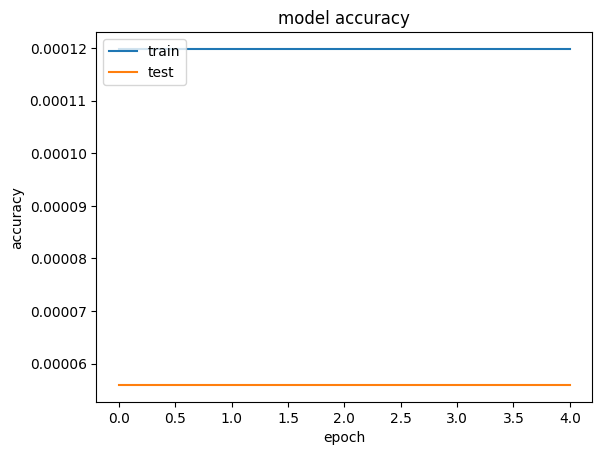

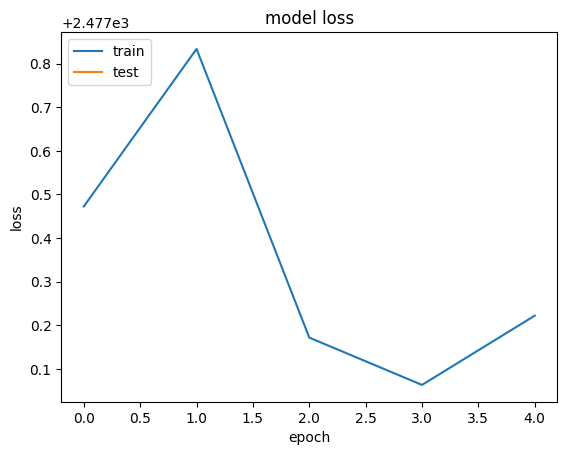

In [31]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


bestModel = keras.models.load_model('Results/bestKerasModel')
#plot(model)


bestModel.reset_states()


compiledBestModel = bestModel.compile(optimizer="RMSprop",  # Adam(learning_rate=0.0001) #RMSprop #sgd
                                      loss="MeanSquaredError",  # 'tf.keras.losses.MeanSquaredError()',
                                      metrics=['MeanAbsoluteError'])

bestModel.reset_states()



xTrainValiPooled = scaled_X[:validationSize,:]
yTrainValiPooled = Y[:validationSize]
history = bestModel.fit(x=xTrainValiPooled, y=yTrainValiPooled, batch_size=32, epochs=5, verbose=2, validation_data = (xWinTest, yTest))


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()




In [44]:
#Visualize network

bestModel = keras.models.load_model('Results/bestKerasModel')

from ann_visualizer.visualize import ann_viz

ann_viz(bestModel, view=True, filename="Results/BestModel1", title="Best Model Visualized")




In [13]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

bestModel = keras.models.load_model('Results/BestKerasModel2')




#Print summary
modelSummary = bestModel.summary()
print(modelSummary)


with open('Results/BestModelSummary.html', 'w') as f:

    bestModel.summary(print_fn=lambda x: f.write(x + '\n'))




# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# import pydot
# import pydotplus
# import graphviz

# tf.keras.utils.plot_model(
#     bestModel,
#     to_file="Results/BestModel.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="LR",
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True,
# )



#pred = model.predict(xWinVal, batch_size=128)

#plt.scatter(pred, yVal)
#pred

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 5)                 430       
                                                                 
 dense_70 (Dense)            (None, 5)                 30        
                                                                 
 dropout_32 (Dropout)        (None, 5)                 0         
                                                                 
 dense_71 (Dense)            (None, 5)                 30        
                                                                 
 dropout_33 (Dropout)        (None, 5)                 0         
                                                                 
 dense_72 (Dense)            (None, 5)                 30        
                                                                 
 dropout_34 (Dropout)        (None, 5)               

In [ ]:
#ynew = model.predict_classes(Xnew)

In [ ]:
#(Geron 2019, 76, 320)

#from sklearn import RandomizedSearchCV, GridSearchCV



#(Geron 2019, 76)
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)



grid_search.best_params_

grid_search.best_estimator_

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)





#(Geron 2019, 320)


def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
        model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model


keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


keras_reg.fit(X_train, y_train, epochs=100,
validation_data=(X_valid, y_valid),
callbacks=[keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_new)




from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=100,
validation_data=(X_valid, y_valid),
callbacks=[keras.callbacks.EarlyStopping(patience=10)])


rnd_search_cv.best_params_
rnd_search_cv.best_score_
model = rnd_search_cv.best_estimator_.model








#Chollet: DL for Python
import kerastuner as kt





#strategy = tf.distribute.MirroredStrategy()





#If your search process crashes, you can always restart it—just specify overwrite=False in the tuner so that it can resume from the trial logs stored on disk.




